<font size="+3"><strong>5 Bankrupcty in Poland 🇵🇱</strong></font>

<font size="+2"><strong>5.5 Bankruptcy in Taiwan 🇹🇼</strong></font>

This notebook resumes the most important things learned in the WorldQuant Applied Data Science Lab course 5 - "Bankruptcy in Poland". It uses the courses' project "Bankruptcy in Taiwan" since it implements the main ideas learned.

In this project, I'll explore data collected by a team of Polish economists studying bankruptcy. The goal is to build a model that can predict whether a company will go bankrupt or not.

Topics learned in this project:

- Navigate a file system from the Linux command line
- Load and save files using Python
- Address imbalanced data using resampling techniques
- Evaluate a model using classification metrics like precision and recall

Imports necessary libraries:

In [1]:
import gzip
import json
import pickle

import ipywidgets as widgets
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from IPython.display import VimeoVideo
from ipywidgets import interact
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
# from teaching_tools.widgets import ConfusionMatrixWidget

## Prepare Data

### Import

To decompress a JSON file one can write the following code in the command line:

`gzip -dkf file-name.json.gz`

d stands for decompress, k for keeping the compressed file, and f to force overwriting.

To use the command line in a Jupyter notebook we use `%%bash` before the command.

To examine the 10 first lines in a JSON file:

`head filename.json`

Opens and loads the contents of a JSON file:

```python
with open("filename.json", "r") as read_file:
    data = json.load(read_file)

Opens and loads the contents of a compressed JSON file:

In [2]:
with gzip.open("data/taiwan-bankruptcy-data.json.gz", "r") as read_file:
    taiwan_data = json.load(read_file)
    
print(type(taiwan_data))

<class 'dict'>


Extracts the key names from the dictionary:

In [3]:
taiwan_data_keys = taiwan_data.keys()
print(taiwan_data_keys)

dict_keys(['schema', 'metadata', 'observations'])


Calculates how many companies are in `taiwan_data`:

In [4]:
n_companies = len(taiwan_data["observations"])
print(n_companies)

6137


Calculates the number of features associated with each company:

In [5]:
n_features = len(taiwan_data["schema"]["fields"])
print(n_features)

97



Creates a `wrangle` function that takes the path to a compressed JSON file (in .gz format) as input.

The function should:
- read and parse the file
- extract the data under the "observations" key
- return it as a pandas DataFrame
- set the "id" field as the DataFrame’s index

In [6]:
def wrangle(path):

    with gzip.open(path, "r") as read_file:
        taiwan_data = json.load(read_file)

    df = pd.DataFrame(taiwan_data["observations"])
    df = df.set_index("id")
    return df

In [7]:
df = wrangle("data/taiwan-bankruptcy-data.json.gz")  
print("df shape:", df.shape)
df.head()

df shape: (6137, 96)


,bankrupt,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
id,,,,,,,,,,,,,,,,,,,,,
1,True,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
2,True,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
3,True,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
4,True,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
5,True,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


### Explore

Creates a Series where the index contains the name of the columns in `df` and the values are the number of `NaNs` in each column:

In [8]:
nans_by_col = df.isnull().sum()
print("nans_by_col shape:", nans_by_col.shape)
nans_by_col.head()

nans_by_col shape: (96,)


bankrupt    0
feat_1      0
feat_2      0
feat_3      0
feat_4      0
dtype: int64

Creates a bar chart that shows the normalized value counts for the column `df["bankrupt"]`:

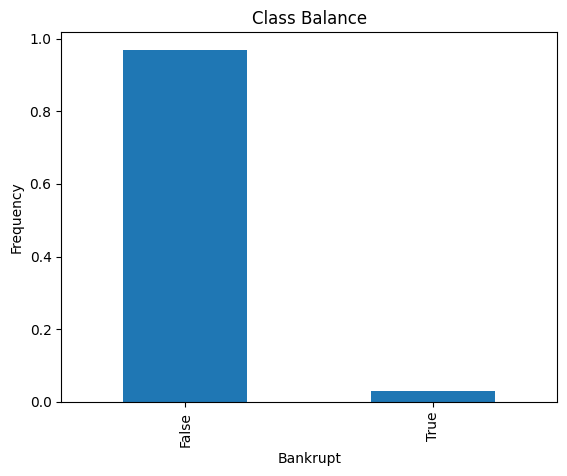

In [9]:
fig, ax = plt.subplots()

df["bankrupt"].value_counts(normalize=True).plot(
    ax=ax,
    kind="bar",
    xlabel="Bankrupt",
    ylabel="Frequency",
    title="Class Balance"
);

<strong>positive class</strong>: the target class that answers “yes” to the question we are evaluating

<strong>negative class</strong>: the target class that answers “no” to the question we are evaluating

### Split

Creates a feature matrix `X` and a target vector `y`:

In [10]:
target = "bankrupt"
X = df.drop(columns=target)
y = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (6137, 95)
y shape: (6137,)


Divides the dataset into training and test sets (`X_train`, `X_test`, `y_train`, `y_test`) using a randomized split:

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4909, 95)
y_train shape: (4909,)
X_test shape: (1228, 95)
y_test shape: (1228,)


### Resample

We can address the class imbalance we saw during the EDA. One strategy is to resample the training data.

<strong>Under-Sampling</strong>: deletes some majority class data points to match the number in the minority class:

```python
under_sampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = under_sampler.fit_resample(X_train, y_train)
```

<strong>Over-Sampling</strong>: adds data points to the minority class to match the majority class data points.



Creates a new feature matrix `X_train_over` and target vector `y_train_over` by performing random over-sampling on the training data:

In [12]:
over_sampler = RandomOverSampler(random_state=42)
X_train_over, y_train_over = over_sampler.fit_resample(X_train, y_train)
print("X_train_over shape:", X_train_over.shape)
X_train_over.head()

X_train_over shape: (9512, 95)


,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_86,feat_87,feat_88,feat_89,feat_90,feat_91,feat_92,feat_93,feat_94,feat_95
0,0.535855,0.599160,0.594411,0.627099,0.627099,0.999220,0.797686,0.809591,0.303518,0.781865,...,0.834091,0.022025,0.624364,0.627101,0.841977,0.275384,0.026791,0.565158,1,0.147943
1,0.554136,0.612734,0.595000,0.607388,0.607388,0.999120,0.797614,0.809483,0.303600,0.781754,...,0.840293,0.002407,0.624548,0.607385,0.842645,0.276532,0.026791,0.565158,1,0.062544
2,0.549554,0.603467,0.599122,0.620166,0.620166,0.999119,0.797569,0.809470,0.303524,0.781740,...,0.840403,0.000840,0.624010,0.620163,0.842873,0.277249,0.026800,0.565200,1,0.047929
3,0.543801,0.603249,0.606992,0.622515,0.622515,0.999259,0.797728,0.809649,0.303510,0.781930,...,0.831514,0.006176,0.626775,0.622513,0.842989,0.280013,0.026839,0.565375,1,0.028386
4,0.498659,0.562364,0.546978,0.603670,0.603670,0.998904,0.797584,0.809459,0.304000,0.781713,...,0.811988,0.004256,0.623674,0.603669,0.841105,0.277628,0.026897,0.565618,1,0.043080


## Build Model

### Random Forest

The performance of a single decision tree will be limited. Instead of relying on one tree, a better approach is to aggregate the predictions of multiple trees. On average, aggregation will perform better than a single predictor.


In order for a random forest to be effective, the model needs a diverse collection of trees. There should be variations in the chosen thresholds for splitting and the number of nodes and branches. There is no point in aggregating the predicted results if all the trees are nearly identical and produce the same result.

Process:

- Train each tree in the forest using a different subset of the training set.
- Only consider a subset of features when deciding how to split the nodes.
- On the first point, we would ideally generate a new training set for each tree. However, oftentimes it's too difficult or expensive to collect more data, so we have to make do with what we have. <strong>Bootstrapping</strong> is a general statistical technique to generate "new" data sets with a single set by random sampling with replacement. 
- <strong>Sampling with replacement</strong> allows for a data point to be sampled more than once.

Typically, when training the standard decision tree model, the algorithm will consider all features in deciding the node split. 

Considering only a subset of your features ensures that your trees do not resemble each other. 

If the algorithm had considered all features, a dominant feature would be continuously chosen for node splits.

The hyperparameters available for random forests include those of decision tress with some additions:

<table>
<tr>
<th style="text-align: left">Hyperparameter</th>
<th style="text-align: left">Description</th>
</tr>
    
<tr>
<td style="text-align: left"><code>n_estimators</code></td>
<td style="text-align: left">The number of trees in the forest</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>max_samples</code></td>
<td style="text-align: left">If bootstrap is True, the number of samples to draw from X to train each base estimator</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>max_features</code></td>
<td style="text-align: left">The number of features to consider when looking for the best split</td>
</tr>

<tr>
<td style="text-align: left"><code>n_jobs</code></td>
<td style="text-align: left">The number of jobs to run in parallel when fitting and predicting</td>
</tr>

<tr style="text-align: left">
<td style="text-align: left"><code>warm_start</code></td>
<td style="text-align: left">If set to <code>True</code>, reuse the trained tree from a prior fitting and just train the additional trees</td>
</tr>
</table>

In sum:
- it is an Ensemble Model that emsembles multiple decision tree’s models
- each prediction is taken into account to make a final prediction
- by default, the number of trees in our forest is 100

Creates a classifier `clf` (predictor) that can be trained on (`X_train_over`, `y_train_over`)

In [13]:
clf = RandomForestClassifier(random_state=42)

Performs <strong>cross-validation</strong> with the classifier using the over-sampled training data:

In [14]:
cv_scores = cross_val_score(clf, X_train_over, y_train_over, cv=5, n_jobs=-1)
print(cv_scores)

[0.99316868 0.99421965 0.99421661 0.99369085 0.9957939 ]


<font size="+1"><strong>Grid Search</strong><font>

Another a useful tool for comparing different hyperparameter values is `GridSearchCV`. 

There are two ideas behind `GridSearchCV`: 
1. we split the data using k-fold cross-validation
2. we train and evaluate models with different hyperparameter settings selected from a grid of possible combinations

First, we need to define the hyperparameters we want to tune, and tuning in what range.

Defines the <strong>hyperparameters</strong> we want to test:

In [15]:
params = {
    "max_depth": range(30, 50, 10),
    "n_estimators": range(25, 51, 25),
}

Creates a `GridSearchCV` named `model` that includes classifier and hyperparameter grid:

In [16]:
model = GridSearchCV(
    clf,
    param_grid=params,
    cv=5,               # Number of cross-validation folds
    n_jobs=-1,          # Number of CPU cores to use for computation (-1 for all available)
    verbose=1           # Controls how much information is printed during execution (1 for basic messages)
)

In [17]:
model.fit(X_train_over, y_train_over)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,estimator,RandomForestC...ndom_state=42)
,param_grid,"{'max_depth': range(30, 50, 10), 'n_estimators': range(25, 51, 25)}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,50


Extracts the cross-validation results from the model.

The results are used to determine which set of hyperparameters led to the best performance.

In [18]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.683694,0.020561,0.006364,0.000891,30,25,"{'max_depth': 30, 'n_estimators': 25}",0.992643,0.992118,0.991588,0.992114,0.993165,0.992325,0.000536,4
1,1.306429,0.053032,0.011146,0.003997,30,50,"{'max_depth': 30, 'n_estimators': 50}",0.993169,0.993694,0.991588,0.994217,0.994217,0.993377,0.000975,2
2,0.745246,0.033346,0.006834,0.001327,40,25,"{'max_depth': 40, 'n_estimators': 25}",0.992118,0.992643,0.994742,0.992639,0.994217,0.993272,0.001018,3
3,1.340365,0.044230,0.008983,0.000423,40,50,"{'max_depth': 40, 'n_estimators': 50}",0.992643,0.994220,0.994217,0.995268,0.995268,0.994323,0.000962,1


Extracts the best hyperparameters from the model:

In [19]:
best_params = model.best_params_
print(best_params)

{'max_depth': 40, 'n_estimators': 50}


### Evaluate

Tests the quality of the model by calculating accuracy scores for the training and test data:

In [20]:
acc_train = model.score(X_train_over, y_train_over)
acc_test = model.score(X_test, y_test)

print("Model Training Accuracy:", round(acc_train, 4))
print("Model Test Accuracy:", round(acc_test, 4))

Model Training Accuracy: 1.0
Model Test Accuracy: 0.978


<font size="+1"><strong>Confusion Matrix</strong></font>

Accuracy score may not provide enough information to assess how a model is performing because it only gives us an overall score. 

Also, imbalanced data can lead to a high accuracy score even when a model isn't particularly useful. 

If we want to know what fraction of all positive predictions were correct and what fraction of positive observations did we identify, we can use a <strong>confusion matrix</strong>.

A confusion matrix is a table summarizing the performance of the model by enumerating true and false positives and the true and false negatives.

|                     | Positive Observation     | Negative Observation    |
|---------------------|:------------------------:|:-----------------------:|
| **Positive Prediction** |     True Positive (`TP`)   | False Positive (`FP`)     |
| **Negative Prediction** | False Negative (`FN`)      |     True Negative (`TN`)  |

Plots a confusion matrix to visualize the model's performance on the test set:

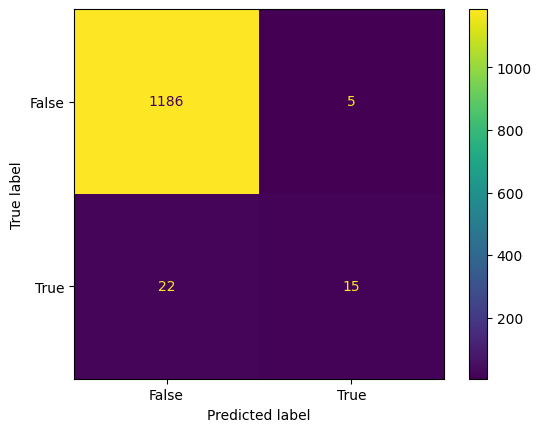

In [21]:
fig, ax = plt.subplots()

ConfusionMatrixDisplay.from_estimator(
    model, 
    X_test, 
    y_test,
    ax=ax
);

<font size="+1"><strong>Classification Report</strong></font>

We can also use a classification report to look at the whole picture of the classification model performances. 

A classification report includes precision, recall, F1 score and support. 

We already know the first two, but F1 score is the harmonic mean of precision and recall.

- <strong>precision score</strong>: how well the model indentifies observations that belong to the positive class without making the error of a false positive

- <strong>recall score</strong>: measures how well the model identifies observations that belong to the positive class


Generates a classification report:

In [22]:
class_report = classification_report(y_test, model.predict(X_test))
print(class_report)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99      1191
        True       0.75      0.41      0.53        37

    accuracy                           0.98      1228
   macro avg       0.87      0.70      0.76      1228
weighted avg       0.97      0.98      0.97      1228



## Communicate

Creates a horizontal bar chart with the 10 most important features for the model:

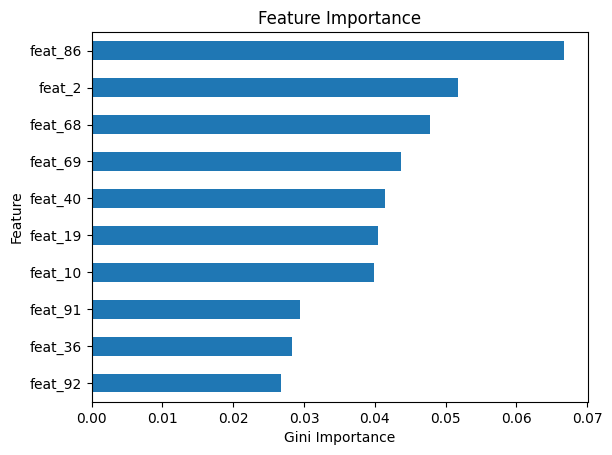

In [23]:
features = X_train_over.columns
importances = model.best_estimator_.feature_importances_
feat_imp = pd.Series(importances, index=features).sort_values()

fig, ax = plt.subplots()

feat_imp.tail(10).plot(
    kind="barh",
    xlabel="Gini Importance",
    ylabel="Feature",
    title="Feature Importance",
    ax=ax
);

Saves the best-performing model to a file named `model-5-5.pkl`:

In [ ]:
with open("model-5-5.pkl", "wb") as f: # wb for write and binary mode
    pickle.dump(model, f)              # serializes an object and saves it to a file in binary format

Creates a `make_predictions` function that takes two arguments: `data_filepath` and `model_filepath`.

The `wrangle` function is imported from the file `my_predictor_assignment.py`.

In [27]:
from my_predictor_assignment import wrangle

def make_predictions(data_filepath, model_filepath):
    
    # wrangle JSON file
    X_test = wrangle(data_filepath)
    
    # load model
    with open(model_filepath, "rb") as f: # r for read and b for binary
        model=pickle.load(f)
        
    #generate predictions
    y_test_pred=model.predict(X_test)
    
    # put predictions into Series with name "bankrupt", and same index as X_test
    y_test_pred=pd.Series(y_test_pred, index=X_test.index, name="bankrupt")

    return y_test_pred
    
# Generate predictions
y_test_pred = make_predictions(
    data_filepath="data/taiwan-bankruptcy-data-test-features.json.gz",
    model_filepath="model-5-5.pkl",
)

print("predictions shape:", y_test_pred.shape)
y_test_pred.head()

predictions shape: (682,)


id
18    False
20    False
24    False
32    False
38    False
Name: bankrupt, dtype: bool